In [1]:
import numpy as np
import re
import numba
import tempfile
import sys
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pickle
from collections import deque

try:
    from tqdm import tqdm
except ModuleNotFoundError:
    def tqdm(a):
        return a

In [2]:
# Random number generator compatible with C++ and FORTRAN versions

_IA=16807
_IM=2147483647
_IQ=127773
_IR=2836
_NTAB=32
_NDIV=(1+(_IM-1)//_NTAB)
_EPS=3.0e-16
_AM=1.0/_IM
_RNMX=(1.0-_EPS)

@numba.njit(cache=True,fastmath=True)
def _U01(idum,iy,iv):
    if idum <= 0 or iy == 0:
        if (-idum < 1):
            idum=1
        else:
            idum=-idum
        for j in range(_NTAB+7,-1,-1):
            k=idum//_IQ
            idum=_IA*(idum-k*_IQ)-_IR*k
            if idum<0:
                idum += _IM
            if j < _NTAB:
                iv[j] = idum
        iy=iv[0]
    k=idum//_IQ
    idum=_IA*(idum-k*_IQ)-_IR*k
    if idum<0:
        idum += _IM
    j=iy//_NDIV
    iy=iv[j]
    iv[j]=idum
    temp=_AM*iy
    if temp > _RNMX:
        temp = _RNMX
    return idum,iy,temp

@numba.njit(cache=True,fastmath=True)
def _U01_loop(idum,iy,iv,numbers):
    for i in range(len(numbers)):
        idum,iy,numbers[i] = _U01(idum,iy,iv)
    return idum,iy

@numba.njit(cache=True,fastmath=True)
def _Gaussian(idum,iy,iv,switchGaussian,saveGaussian):
    if(switchGaussian):
        return idum,iy,False,0.0,saveGaussian
    else:
        while True:
            idum,iy,r1=_U01(idum,iy,iv)
            idum,iy,r2=_U01(idum,iy,iv)
            v1=2.0*r1-1.0
            v2=2.0*r2-1.0
            rsq=v1*v1+v2*v2
            if(rsq<1.0 and rsq>0.0):
                break
        fac=np.sqrt(-2.0*np.log(rsq)/rsq)
        return idum,iy,True,v1*fac,v2*fac

@numba.njit(cache=True,fastmath=True)
def _Gaussian_loop(idum,iy,iv,switchGaussian,saveGaussian,numbers):
    for i in range(len(numbers)):
        idum,iy,switchGaussian,saveGaussian,numbers[i] = _Gaussian(
            idum,iy,iv,switchGaussian,saveGaussian
    )
    return idum,iy,switchGaussian,saveGaussian

class Random():
    def __init__(self,seed=0):
        self.switchGaussian=False
        self.saveGaussian=0.0
        self.iy=0
        self.iv=np.zeros(_NTAB, dtype=int)
        self.idum=0
        self.idum=seed
    def U01(self,shape=None):
        if shape is None:
            self.idum,self.iy,temp = _U01(self.idum,self.iy,self.iv)
            return temp
        else:
            numbers=np.zeros(np.prod(shape))
            self.idum,self.iy = _U01_loop(self.idum,self.iy,self.iv,numbers)
            return numbers.reshape(shape)

    def Gaussian(self,shape=None):
        if shape is None:
            self.idum,self.iy,self.switchGaussian,self.saveGaussian,temp=_Gaussian(
                self.idum,self.iy,self.iv,self.switchGaussian,self.saveGaussian
            )
            return temp
        else:
            numbers=np.zeros(np.prod(shape))
            self.idum,self.iy,self.switchGaussian,self.saveGaussian=_Gaussian_loop(
                self.idum,self.iy,self.iv,self.switchGaussian,self.saveGaussian,numbers
            )
            return numbers.reshape(shape)

In [3]:
@numba.njit(cache=True,fastmath=True)
def _compute_rgyr2(positions,cell):
    meanx=0.0
    meany=0.0
    meanz=0.0
    for i in range(len(positions)):
        meanx+=positions[i,0]
        meany+=positions[i,1]
        meanz+=positions[i,2]
    meanx/=len(positions)
    meany/=len(positions)
    meanz/=len(positions)
    
    rgyr2=0.0
    for i in range(len(positions)):
        distancex=positions[i,0]-meanx
        distancey=positions[i,1]-meany
        distancez=positions[i,2]-meanz
        distancex-=np.floor(distancex/cell[0]+0.5)*cell[0]
        distancey-=np.floor(distancey/cell[1]+0.5)*cell[1]
        distancez-=np.floor(distancez/cell[2]+0.5)*cell[2]
        rgyr2+=distancex**2+distancey**2+distancez**2
    rgyr2/=len(positions)
    return rgyr2

@numba.njit(cache=True,fastmath=True)
def _compute_SAXS(positions, cell, q_SAXS, a_SAXS,b_SAXS,c_SAXS):

    SAXS=np.zeros(len(q_SAXS))

    for q in range(len(q_SAXS)):
        q_factor=(q_SAXS[q]/(4*np.pi))**2
        scattering=c_SAXS
        for s in range(4):
            scattering+=a_SAXS[s]*np.exp(-b_SAXS[s]*q_factor)

        scattering2=scattering**2
        
        for i in range(len(positions)):
            for j in range(i+1,len(positions)):
                distancex=positions[i,0]-positions[j,0]
                distancey=positions[i,1]-positions[j,1]
                distancez=positions[i,2]-positions[j,2]
                distancex-=np.floor(distancex/cell[0]+0.5)*cell[0]
                distancey-=np.floor(distancey/cell[1]+0.5)*cell[1]
                distancez-=np.floor(distancez/cell[2]+0.5)*cell[2]
                distance2=distancex**2+distancey**2+distancez**2
                distance=np.sqrt(distance2)
                SAXS[q]+=np.sin(q_SAXS[q]*distance)/(q_SAXS[q]*distance)

        SAXS[q]=SAXS[q]*scattering2

    return SAXS

@numba.njit(cache=True,fastmath=True)
def _compute_angle(positions, cell):
    angle=np.zeros(len(positions) - 2)

    for i in range(len(positions) - 2):
        ri = positions[i]
        rj = positions[i+1]
        rk = positions[i+2]

        distance1x = ri[0] - rj[0]
        distance1y = ri[1] - rj[1]
        distance1z = ri[2] - rj[2]
        distance2x = rk[0] - rj[0]
        distance2y = rk[1] - rj[1]
        distance2z = rk[2] - rj[2]

        distance1x -= np.floor(distance1x / cell[0] + 0.5) * cell[0]
        distance1y -= np.floor(distance1y / cell[1] + 0.5) * cell[1]
        distance1z -= np.floor(distance1z / cell[2] + 0.5) * cell[2]
        distance2x -= np.floor(distance2x / cell[0] + 0.5) * cell[0]
        distance2y -= np.floor(distance2y / cell[1] + 0.5) * cell[1]
        distance2z -= np.floor(distance2z / cell[2] + 0.5) * cell[2]

        r12 = distance1x**2 + distance1y**2 + distance1z**2
        r22 = distance2x**2 + distance2y**2 + distance2z**2
        r1 = np.sqrt(r12)
        r2 = np.sqrt(r22)
        dot = distance1x * distance2x + distance1y * distance2y + distance1z * distance2z
        cos = dot / (r1 * r2)
        angle[i]=np.arccos(cos)
    return angle

@numba.njit(cache=True,fastmath=True)
def _compute_forces(cell, positions, forcecutoff, neighbors, point, forces, k_fene, maxbond, k_angle, l_rgyr2, q_SAXS, l_SAXS,a_SAXS,b_SAXS,c_SAXS, fm):
    engconf=0.0
    forces.fill(0.0)
    forcecutoff2=forcecutoff*forcecutoff
    engcorrection=4.0*(1.0/forcecutoff2**6-1.0/forcecutoff2**3)
    maxbond2=maxbond*maxbond

    #LJ
    for i in range(len(positions)):
        for j in range(point[i],point[i+1]):
            ja=neighbors[j]
            distancex=positions[i,0]-positions[ja,0]
            distancey=positions[i,1]-positions[ja,1]
            distancez=positions[i,2]-positions[ja,2]
            distancex-=np.floor(distancex/cell[0]+0.5)*cell[0]
            distancey-=np.floor(distancey/cell[1]+0.5)*cell[1]
            distancez-=np.floor(distancez/cell[2]+0.5)*cell[2]
            distance2=distancex**2+distancey**2+distancez**2
            if distance2 <= forcecutoff2:
                invdistance2=1.0/distance2
                invdistance6=invdistance2*invdistance2*invdistance2
                e=4.0*invdistance6*invdistance6-4.0*invdistance6-engcorrection
                engconf+=e
                fmod=2.0*4.0*(6.0*invdistance6*invdistance6-3.0*invdistance6)*invdistance2
                fx=fmod*distancex
                fy=fmod*distancey
                fz=fmod*distancez
                forces[i,0]+=fx
                forces[i,1]+=fy
                forces[i,2]+=fz
                forces[ja,0]-=fx
                forces[ja,1]-=fy
                forces[ja,2]-=fz

    #FENE
    for i in range(len(positions)-1):
        distancex=positions[i+1,0]-positions[i,0]
        distancey=positions[i+1,1]-positions[i,1]
        distancez=positions[i+1,2]-positions[i,2]
        distancex -= np.floor(distancex / cell[0] + 0.5) * cell[0]
        distancey -= np.floor(distancey / cell[1] + 0.5) * cell[1]
        distancez -= np.floor(distancez / cell[2] + 0.5) * cell[2]
        distance2=distancex**2+distancey**2+distancez**2
        if distance2 < maxbond2:
            engconf+=-0.5*k_fene*maxbond2*np.log(1-distance2/(maxbond2))
            prefactor=k_fene/(1-distance2/(maxbond2))
            fx=prefactor*distancex
            fy=prefactor*distancey
            fz=prefactor*distancez
            forces[i,0]+=fx
            forces[i,1]+=fy
            forces[i,2]+=fz
            forces[i+1,0]-=fx
            forces[i+1,1]-=fy
            forces[i+1,2]-=fz

    #ANGULAR POTENTIAL
    for i in range(len(positions) - 2):
        ri = positions[i]
        rj = positions[i+1]
        rk = positions[i+2]

        distance1x = ri[0] - rj[0]
        distance1y = ri[1] - rj[1]
        distance1z = ri[2] - rj[2]
        distance2x = rk[0] - rj[0]
        distance2y = rk[1] - rj[1]
        distance2z = rk[2] - rj[2]

        distance1x -= np.floor(distance1x / cell[0] + 0.5) * cell[0]
        distance1y -= np.floor(distance1y / cell[1] + 0.5) * cell[1]
        distance1z -= np.floor(distance1z / cell[2] + 0.5) * cell[2]
        distance2x -= np.floor(distance2x / cell[0] + 0.5) * cell[0]
        distance2y -= np.floor(distance2y / cell[1] + 0.5) * cell[1]
        distance2z -= np.floor(distance2z / cell[2] + 0.5) * cell[2]

        r12 = distance1x**2 + distance1y**2 + distance1z**2
        r22 = distance2x**2 + distance2y**2 + distance2z**2
        r1 = np.sqrt(r12)
        r2 = np.sqrt(r22)
        dot = distance1x * distance2x + distance1y * distance2y + distance1z * distance2z
        cos = dot / (r1 * r2)

        # Energy
        engconf += k_angle * cos

        # Force on i 
        fi_x = -k_angle * (distance2x / (r1 * r2) - cos * distance1x / r12)
        fi_y = -k_angle * (distance2y / (r1 * r2) - cos * distance1y / r12)
        fi_z = -k_angle * (distance2z / (r1 * r2) - cos * distance1z / r12)

        # Force on k 
        fk_x = -k_angle * (distance1x / (r1 * r2) - cos * distance2x / r22)
        fk_y = -k_angle * (distance1y / (r1 * r2) - cos * distance2y / r22)
        fk_z = -k_angle * (distance1z / (r1 * r2) - cos * distance2z / r22)

        # Force on j
        fj_x = -(fi_x + fk_x)
        fj_y = -(fi_y + fk_y)
        fj_z = -(fi_z + fk_z)

        forces[i,0] += fi_x
        forces[i,1] += fi_y
        forces[i,2] += fi_z

        forces[i+1,0] += fj_x
        forces[i+1,1] += fj_y
        forces[i+1,2] += fj_z

        forces[i+2,0] += fk_x
        forces[i+2,1] += fk_y
        forces[i+2,2] += fk_z

        


    

    #RGYR2
    meanx=0.0
    meany=0.0
    meanz=0.0
    for i in range(len(positions)):
        meanx+=positions[i,0]
        meany+=positions[i,1]
        meanz+=positions[i,2]
    meanx/=len(positions)
    meany/=len(positions)
    meanz/=len(positions)

    rgyr2=0.0
    for i in range(len(positions)):
        distancex=positions[i,0]-meanx
        distancey=positions[i,1]-meany
        distancez=positions[i,2]-meanz
        distancex-=np.floor(distancex/cell[0]+0.5)*cell[0]
        distancey-=np.floor(distancey/cell[1]+0.5)*cell[1]
        distancez-=np.floor(distancez/cell[2]+0.5)*cell[2]
        rgyr2+=distancex**2+distancey**2+distancez**2
    rgyr2/=len(positions)

    engconf+=l_rgyr2*rgyr2

    for i in range(len(positions)):
        distancex=positions[i, 0]-meanx
        distancey=positions[i, 1]-meany
        distancez=positions[i, 2]-meanz
        distancex-=np.floor(distancex/cell[0]+0.5)*cell[0]
        distancey-=np.floor(distancey/cell[1]+0.5)*cell[1]
        distancez-=np.floor(distancez/cell[2]+0.5)*cell[2]
        fx=(2*l_rgyr2*distancex)/len(positions) 
        fy=(2*l_rgyr2*distancey)/len(positions) 
        fz=(2*l_rgyr2*distancez)/len(positions) 
        forces[i, 0]-=fx
        forces[i, 1]-=fy
        forces[i, 2]-=fz

    #SAXS
    
    for q in range(len(q_SAXS)):
        SAXS=0
        scattering=c_SAXS
        for s in range(4):
            scattering+=a_SAXS[s]*np.exp(-b_SAXS[s]*(q_SAXS[q]/(4*np.pi))**2)

        scattering2=scattering**2
        
        for i in range(len(positions)):
            for j in range(i+1,len(positions)):
                distancex=positions[i,0]-positions[j,0]
                distancey=positions[i,1]-positions[j,1]
                distancez=positions[i,2]-positions[j,2]
                distancex-=np.floor(distancex/cell[0]+0.5)*cell[0]
                distancey-=np.floor(distancey/cell[1]+0.5)*cell[1]
                distancez-=np.floor(distancez/cell[2]+0.5)*cell[2]
                distance2=distancex**2+distancey**2+distancez**2
                distance=np.sqrt(distance2)
                fmod=-scattering2*l_SAXS[q]*fm[0]*(q_SAXS[q]*distance*np.cos(q_SAXS[q]*distance)-np.sin(q_SAXS[q]*distance))/(q_SAXS[q]*distance**3)
                fx=fmod*distancex
                fy=fmod*distancey
                fz=fmod*distancez
                forces[i,0]+=fx
                forces[i,1]+=fy
                forces[i,2]+=fz
                forces[j,0]-=fx
                forces[j,1]-=fy
                forces[j,2]-=fz
                SAXS+=np.sin(q_SAXS[q]*distance)/(q_SAXS[q]*distance)

        engconf+=l_SAXS[q]*scattering2*(fm[0]*SAXS+fm[1])

    return engconf


def _update_parameters(istep, tstep, temperature, SAXS, exp_SAXS, sigma_SAXS, lambda_SAXS, fm, eta_lambda0, tau_lambda, eta_theta0, tau_theta, engint,alpha,beta):

    
    

    fm_SAXS = fm[0] * SAXS + fm[1] 

    engint+=temperature*np.dot(lambda_SAXS , fm_SAXS)

    #gradients
    grad_lambda = exp_SAXS - fm_SAXS + alpha * (sigma_SAXS**2) * lambda_SAXS
    grad_a = alpha*np.dot(lambda_SAXS , SAXS)+beta/fm[0]
    grad_b = alpha*np.sum(lambda_SAXS) 

    #learning rates
    eta_lambda = eta_lambda0 / (1 + istep / tau_lambda)
    eta_theta = eta_theta0 / (1 + istep / tau_theta)
    

    #update
    lambda_SAXS -= eta_lambda * grad_lambda * tstep 
    fm[0] -= eta_theta[0] * grad_a * tstep
    if fm[0]<0:
        fm[0]=-fm[0]
    fm[1] -= eta_theta[1] * grad_b * tstep

    fm_SAXS = fm[0] * SAXS + fm[1] 
    engint-=temperature*np.dot(lambda_SAXS , fm_SAXS)

    return engint
    
def _update_ff(istep, tstep, temperature, SAXS, exp_SAXS, sigma_SAXS, cov, var, angle, k_angle, eta_ff0, tau_ff, engint,beta):
    
    
    engint+=k_angle*np.sum(np.cos(angle))

    eta_ff = eta_ff0 / (1 + istep / tau_ff)
    grad=(-1/temperature)*np.dot(cov,(SAXS-exp_SAXS)/(sigma_SAXS**2))+(beta/(temperature**2))*k_angle*var
    k_angle-=eta_ff * grad * tstep

    engint-=k_angle*np.sum(np.cos(angle))

    return k_angle, engint

def _update_full(istep, tstep, temperature, SAXS, exp_SAXS, sigma_SAXS, lambda_SAXS, fm, k_l, tau_l, k_fm, tau_fm, mean_ff, var_ff, angle, k_angle, k_ff, tau_ff,engint,delay,alpha,beta,gamma):
    
    
    

    fm_SAXS = fm[0] * SAXS + fm[1] 

    engint+=temperature*np.dot(lambda_SAXS , fm_SAXS) +k_angle*np.sum(np.cos(angle))

    #gradients
    if istep > delay:
        grad_ff= alpha* (1/temperature)*(np.sum(np.cos(angle))-mean_ff)+beta*(1/(temperature**2))*k_angle*var_ff
    else:
        grad_ff=0.0
    grad_l = exp_SAXS - fm_SAXS + alpha * (sigma_SAXS**2) * lambda_SAXS
    grad_a = alpha*np.dot(lambda_SAXS , SAXS)+gamma/fm[0]
    grad_b = alpha*np.sum(lambda_SAXS) 

    #learning rates
    eta_l = k_l / (1 + istep / tau_l)
    eta_fm = k_fm / (1 + istep / tau_fm)
    eta_ff= k_ff / (1 + istep / tau_ff)

    #update
    lambda_SAXS -= eta_l * grad_l * tstep 
    k_angle-= eta_ff*grad_ff* tstep
    fm[0] -= eta_fm[0] * grad_a * tstep
    if fm[0]<0:
        fm[0]=-fm[0]
    fm[1] -= eta_fm[1] * grad_b * tstep

    fm_SAXS = fm[0] * SAXS + fm[1] 
    engint-=temperature*np.dot(lambda_SAXS , fm_SAXS)+k_angle*np.sum(np.cos(angle))

    return k_angle, engint
    
    

@numba.njit(cache=True,fastmath=True)
def _compute_list(cell,positions,listcutoff,nlist,point):
   listcutoff2=listcutoff**2
   point[0]=0
   for i in range(len(positions)):
       point[i+1]=point[i]
       for j in range(i+1,len(positions)):
            distancex=positions[i,0]-positions[j,0]
            distancey=positions[i,1]-positions[j,1]
            distancez=positions[i,2]-positions[j,2]
            distancex-=np.floor(distancex/cell[0]+0.5)*cell[0]
            distancey-=np.floor(distancey/cell[1]+0.5)*cell[1]
            distancez-=np.floor(distancez/cell[2]+0.5)*cell[2]
            distance2=distancex**2+distancey**2+distancez**2
            if distance2 <= listcutoff2:
                if point[i+1]>=len(nlist):
                    raise Exception("Verlet list size exceeded\nIncrease maxneighbours")
                nlist[point[i+1]]=j
                point[i+1]+=1


def generate_lattice(n=1, a0=1.6796):
    coord=np.zeros((4*n*n*n,3))
    l=0
    for i in range(n):
       for j in range(n):
           for k in range(n):
               coord[l]=(i,j,k)
               l+=1
               coord[l]=(i+0.5,j,k+0.5)
               l+=1
               coord[l]=(i+0.5,j+0.5,k)
               l+=1
               coord[l]=(i,j+0.5,k+0.5)
               l+=1
    return ((n*a0,n*a0,n*a0),coord*a0)

def generate_chain(n=1, a0=1.):
    coord=np.zeros((n,3))
    for i in range(n):
        coord[i]=(0,0,i)

    return coord*a0

@numba.njit(cache=True,fastmath=True)
def Gamma(x, s, s_exp):
    weights = np.exp(-x * (s - s_exp))
    
    return np.log(np.sum(weights) / len(s))

def read_input(file):
    keys={}
    with open(file,"r") as f:
        for line in f:
            line=re.sub("#.*$","",line)
            line=re.sub(" *$","",line)
            words=line.split()
            if len(words)==0:
                continue
            key=words[0]
            if key=="temperature":
                keys["temperature"]=float(words[1])
            elif key=="tstep":
                keys["tstep"]=float(words[1])
            elif key=="friction":
                keys["friction"]=float(words[1])
            elif key=="forcecutoff":
                keys["forcecutoff"]=float(words[1])
            elif key=="listcutoff":
                keys["listcutoff"]=float(words[1])
            elif key=="nstep":
                keys["nstep"]=int(words[1])
            elif key=="nconfig":
                keys["nconfig"]=int(words[1])
                keys["trajfile"]=words[2]
            elif key=="nstat":
                keys["nstat"]=int(words[1])
                keys["statfile"]=words[2]
            elif key=="wrapatoms":
                if re.match("[Tt].*",words[1]):
                    keys["wrapatoms"]=True
            elif key=="maxneighbours":
                keys["maxneighbors"]=int(words[1])
            elif key=="inputfile":
                keys["inputfile"]=words[1]
            elif key=="outputfile":
                keys["outputfile"]=words[1]
            elif key=="idum":
                keys["idum"]=int(words[1])
            else:
                raise Exception("Unknown keyword: "+key)
    return keys

def read_positions(file):
    with open(file,"r") as f:
        natoms=int(f.readline())
        cell=[float(x) for x in f.readline().split()]
        positions=np.loadtxt(f,usecols=(1,2,3))
    assert(len(positions)==natoms)
    return np.array(cell),np.array(positions)

# note: this can act on a vector of vectors
def pbc(cell,vector):
    return vector-np.floor(vector/cell+0.5)*cell

def write_trajectory(file,trajectory,*,wrapatoms=False):
    with open(file,"w") as f:
        for cell,positions in trajectory:
            print("%d" % len(positions), file=f)
            print("%f %f %f" % (cell[0], cell[1], cell[2]), file=f)
            if wrapatoms:
                positions = pbc(cell,positions)
            np.savetxt(f,positions,fmt="Ar %10.7f %10.7f %10.7f")

def stable_softmax(logw):
    # logw: array (N,) di log-pesi
    m = np.max(logw)
    w = np.exp(logw - m)      # ora sicuro numericamente
    return w / w.sum()

def weighted_mean_var(values, logw):
    p = stable_softmax(logw)
    mu = np.sum(p * values)
    var = np.sum(p * (values - mu)**2)
    return mu, var, p



In [4]:
class SimpleMD:
    def __init__(self,*,
                temperature=1.0,
                maxneighbors=5000,
                tstep=0.005,
                friction=0.0,
                forcecutoff=2.5,
                k_fene=0.0,
                maxbond=0.0,
                k_angle=0.0,
                l_rgyr2=0.0,
                exp_rgyr2=None,
                k_rgyr2=None,
                tau_rgyr2=None,
                alpha_rgyr2=0,
                sigma_rgyr2=0,
                q_SAXS=[1.0],
                l_SAXS=None,
                a_SAXS=[0.0,0.0,0.0,0.0],
                b_SAXS=[0.0,0.0,0.0,0.0],
                c_SAXS=1.0,
                exp_SAXS=None,
                k_SAXS=None,
                tau_SAXS=None,
                alpha=1.0,
                beta=1.0,
                gamma=1.0,
                sigma_SAXS=None,
                k_fm=[0.0,0.0],
                tau_fm=1.0,
                k_ff=0.0,
                tau_ff=1.0,
                listcutoff=3.0,
                nstep=1,
                nconfig=10,
                nstat=1,
                nequilib=1,
                nonthefly=0,
                nupdate=1,
                idum=0,
                wrapatoms=False,
                statfile=None,
                inputfile=None,
                outputfile=None,
                trajfile=None,
                cell=None,
                positions=None):


        self.iv=np.zeros(32,dtype=int)
        self.iy=0
        self.iset=0
        self.gset=0.0
        self.write_positions_first=True
        self.write_statistics_first=True
        self.write_statistics_last_time_reopened=0
        self.write_statistics_fp=None

        self.temperature=temperature
        self.maxneighbors=maxneighbors
        self.tstep=tstep
        self.friction=friction
        self.forcecutoff=forcecutoff
        self.k_fene=k_fene
        self.maxbond=maxbond
        self.k_angle=k_angle
        self.l_rgyr2=l_rgyr2
        self.exp_rgyr2=exp_rgyr2
        self.k_rgyr2=k_rgyr2
        self.tau_rgyr2=tau_rgyr2
        self.alpha_rgyr2=alpha_rgyr2
        self.sigma_rgyr2=sigma_rgyr2
        self.q_SAXS=q_SAXS
        if l_SAXS is None:
            self.l_SAXS=np.zeros(len(self.q_SAXS))
        else:
            self.l_SAXS=np.array(l_SAXS)
        self.a_SAXS=a_SAXS
        self.b_SAXS=b_SAXS
        self.c_SAXS=c_SAXS
        if exp_SAXS is not None:
            self.exp_SAXS=np.array(exp_SAXS)
        else:
            self.exp_SAXS=None
        self.k_SAXS=k_SAXS
        self.tau_SAXS=tau_SAXS
        self.alpha=alpha
        self.beta=beta
        self.gamma=gamma
        if sigma_SAXS is None:
            self.sigma_SAXS=np.zeros(len(self.q_SAXS))
        else:
            self.sigma_SAXS=np.array(sigma_SAXS)
        self.k_fm=np.array(k_fm)
        self.tau_fm=tau_fm
        self.eta_ff0=k_ff
        self.tau_ff=tau_ff
        self.listcutoff=listcutoff
        self.nstep=nstep
        self.nconfig=nconfig
        self.nstat=nstat
        self.nequilib=nequilib
        self.nonthefly=nonthefly
        self.nupdate=nupdate
        self.idum=idum
        self.wrapatoms=wrapatoms
        self.statfile=statfile
        self.trajfile=trajfile
        self.outputfile=outputfile
        self.inputfile=inputfile
        if positions is not None:
            self.positions=+positions
        else:
            self.positions=None
        self.cell=cell
        
        self.statfile_f=None

        self.statistics=[]
        self.lambda_otf=np.zeros((len(self.q_SAXS),self.nstep//self.nstat))
        self.SAXS_otf=np.zeros((len(self.q_SAXS),self.nstep//self.nstat))
        self.fm_otf=np.zeros((2,self.nstep//self.nstat))
        self.trajectory=[]
        self.SAXS=np.zeros(len(self.q_SAXS))
        self.grad_lambda=np.zeros((len(self.q_SAXS),self.nstep//self.nstat))
        self.angle=np.zeros((len(self.q_SAXS)-2,self.nstep//self.nstat))

        if positions is not None and cell is None:
           raise Exception("either pass both cell and positions or none of them")
        if positions is None and cell is not None:
           raise Exception("either pass both cell and positions or none of them")

        if self.inputfile is None and positions is None:
            raise Exception("Either specify input file or positions")
        if self.inputfile is not None and positions is not None:
            raise Exception("Either specify input file or positions")

    def randomize_velocities(self,temperature,masses,random):
       return np.sqrt(temperature/masses)[:,np.newaxis]*random.Gaussian(shape=(len(masses),3))

    def check_list(self,positions,positions0,listcutoff,forcecutoff):
       delta2=(0.5*(listcutoff-forcecutoff))*(0.5*(listcutoff-forcecutoff))
       disp2=np.sum((positions-positions0)**2,axis=1)
       return np.any(disp2>delta2)

    def compute_engkin(self,masses,velocities):
        return 0.5*np.sum(masses*np.sum(velocities**2,axis=1))

    def thermostat(self,masses,dt,friction,temperature,velocities,engint,random):
        c1=np.exp(-friction*dt)
        c2=np.sqrt((1.0-c1*c1)*temperature)/np.sqrt(masses)
        engint+=0.5*np.sum(masses*np.sum(velocities**2,axis=1))
        velocities=c1*velocities+c2[:,np.newaxis]*random.Gaussian(shape=velocities.shape)
        engint-=0.5*np.sum(masses*np.sum(velocities**2,axis=1))
        return velocities,engint

    def write_positions(self,cell,positions,wrapatoms=False):
        if self.trajfile:
            mode="w"
            if self.write_positions_first:
                self.write_positions_first = False
                mode="w"
            else:
                mode="a"
     
            with open(self.trajfile,mode) as f:
                print("%d" % len(positions), file=f)
                print("%f %f %f" % (cell[0], cell[1], cell[2]), file=f)
                if wrapatoms:
                    positions = pbc(cell,positions)
                np.savetxt(f,positions,fmt="Ar %10.7f %10.7f %10.7f")
        else:
            if wrapatoms:
               positions = pbc(cell,positions)
            self.trajectory.append((cell,+positions))

    def write_final_positions(self,cell,positions,wrapatoms=False):
        if self.outputfile:
            with open(self.outputfile,"w") as f:
                print("%d" % len(positions), file=f)
                print("%f %f %f" % (cell[0], cell[1], cell[2]), file=f)
                if wrapatoms:
                    positions = pbc(cell,positions)
                np.savetxt(f,positions,fmt="Ar %10.7f %10.7f %10.7f")
        else:
            if wrapatoms:
               positions = pbc(cell,positions)
            self.output=(cell,positions)

    def write_statistics(self,istep,tstep,natoms,engkin,engconf,engint,rgyr2,l_rgyr2,k_angle,mean_w,mean_ff):
         if self.statfile:
             if self.write_statistics_fp is None:
                 self.write_statistics_fp = open(self.statfile, "w")
             if istep-self.write_statistics_last_time_reopened>100:
                 self.write_statistics_fp.close()
                 self.write_statistics_fp = open(self.statfile, "a")
                 self.write_statistics_last_time_reopened=istep
             print("%d %f %f %f %f %f %f %f" %
                   (istep,istep*tstep,2.0*engkin/(3.0*natoms),engconf,engkin+engconf,engkin+engconf+engint,rgyr2,l_rgyr2,k_angle,mean_w,mean_ff),
                   file=self.write_statistics_fp)
         else:
              self.statistics.append((istep,istep*tstep,2.0*engkin/(3.0*natoms),engconf,engkin+engconf,engkin+engconf+engint,rgyr2,l_rgyr2,k_angle,mean_w,mean_ff))

    def write_otf(self,i,l_SAXS,SAXS,fm):
        self.lambda_otf[:,i-1]=l_SAXS
        self.SAXS_otf[:,i-1]=fm[0]*SAXS+fm[1]
        self.fm_otf[:,i-1]=fm

    def write_angle(self,i,positions,cell):
        angle=_compute_angle(positions,cell)
        self.angle[:,i-1]=angle
        


    def run(self):
        if self.positions is None:
            self.cell,self.positions=read_positions(self.inputfile)

        random=Random(self.idum)

        # masses are hardcoded to 1
        masses=np.ones(len(self.positions))

        # energy integral initialized to 0
        engint=0.0

        # velocities are randomized according to temperature
        velocities=self.randomize_velocities(self.temperature,masses,random)

        # allocate space for neighbor lists
        nlist=np.zeros(self.maxneighbors*len(self.positions), dtype=int)
        point=np.zeros(len(self.positions)+1, dtype=int)
        # neighbour list are computed
        _compute_list(self.cell, self.positions, self.listcutoff, nlist, point)

        #print("Neighbour list recomputed at step ",0)
        #print("List size: ",len(nlist))

        # reference positions are saved
        positions0=+self.positions

        rgyr2=_compute_rgyr2(self.positions,self.cell)
        SAXS=_compute_SAXS(self.positions,self.cell,self.q_SAXS,self.a_SAXS,self.b_SAXS,self.c_SAXS)

        forces=np.zeros(shape=self.positions.shape)

        #forward models for SAXS
        fm_SAXS=np.array([1.0, 0.0])
        
        # forces are computed before starting md
        engconf= _compute_forces(self.cell, self.positions, self.forcecutoff, nlist, point, forces, self.k_fene, self.maxbond,self.k_angle,self.temperature*self.l_rgyr2,self.q_SAXS,self.temperature*self.l_SAXS,self.a_SAXS,self.b_SAXS,self.c_SAXS, fm_SAXS)

        #sums for ff refinement
        mean_SAXS=np.zeros(len(self.q_SAXS))
        mean_g=0.0
        mean_fg=np.zeros(len(self.q_SAXS))
        mean_gg=0.0
        
        

        #everage after onthefly evolution
        l_rgyr2_avg=0.0
        l_SAXS_avg=np.zeros(len(self.q_SAXS))
        fm_SAXS_avg=np.array([1.0, 0.0])
        k_angle_avg=0.0
        average=False

        M = 10000
        window_w = deque(maxlen=M)
        window_g = deque(maxlen=M)
        window_phi = deque(maxlen=M)
        mean_ff=0
        var_ff=0
        


        # here is the main md loop
        # Langevin thermostat is applied before and after a velocity-Verlet integrator
        # the overall structure is:
        #   thermostat
        #   update velocities
        #   update positions
        #   (eventually recompute neighbour list)
        #   compute forces
        #   update velocities
        #   thermostat
        #   (eventually dump output informations)

        for istep in tqdm(range(self.nstep)):
            if self.friction>0:
                velocities,engint = self.thermostat(masses,0.5*self.tstep,self.friction,self.temperature,velocities,engint,random)

            velocities+=forces*0.5*self.tstep/masses[:,np.newaxis]
            self.positions+=velocities*self.tstep

            check_list=self.check_list(self.positions,positions0,self.listcutoff,self.forcecutoff)
            if check_list:
                _compute_list(self.cell, self.positions, self.listcutoff, nlist, point)
                positions0=+self.positions
                #print("Neighbour list recomputed at step ",istep)
                #print("List size: ",len(nlist))


            rgyr2=_compute_rgyr2(self.positions,self.cell)
            SAXS=_compute_SAXS(self.positions,self.cell,self.q_SAXS,self.a_SAXS,self.b_SAXS,self.c_SAXS)
            angle=_compute_angle(self.positions,self.cell)
            cos=np.sum(np.cos(angle))
            g=cos
            mean_SAXS+=(SAXS-mean_SAXS)/(istep+1)
            mean_g+=(g-mean_g)/(istep+1)
            mean_fg+=(SAXS*g-mean_fg)/(istep+1)
            mean_gg+=(g**2-mean_gg)/(istep+1)
            cov=mean_fg-mean_SAXS*mean_g
            var=mean_gg-mean_g**2

            lw=np.dot(self.l_SAXS , fm_SAXS[0]*SAXS + fm_SAXS[1])
            window_w.append(lw)
            window_g.append(g)
            window_phi.append(self.k_angle)
            values=np.array(list(window_g))
            phi=np.array(list(window_phi))
            logw=np.array(list(window_w))-(1/self.temperature)*(self.k_angle-phi)*values
            mean_ff, var_ff, p =weighted_mean_var(values, logw)



            if istep>self.nequilib+self.nonthefly:
                

                if not average and self.nonthefly>0:
                    engint+=self.temperature*np.dot(self.l_SAXS , fm_SAXS[0]*SAXS + fm_SAXS[1])+self.k_angle*cos
                    self.l_rgyr2=l_rgyr2_avg/(self.nonthefly/2)
                    self.l_SAXS=l_SAXS_avg/(self.nonthefly/2)
                    fm_SAXS[0]=fm_SAXS_avg[0]/(self.nonthefly/2)
                    fm_SAXS[1]=fm_SAXS_avg[1]/(self.nonthefly/2)
                    self.k_angle=k_angle_avg/(self.nonthefly/2)
                    engint-=self.temperature*np.dot(self.l_SAXS , fm_SAXS[0]*SAXS + fm_SAXS[1])+self.k_angle*cos
                    average=True
                self.SAXS+=fm_SAXS[0]*SAXS+fm_SAXS[1]

            if istep>self.nequilib and istep<=self.nequilib+self.nonthefly:
                if self.exp_rgyr2 is not None:
                    coef_rgyr2=self.k_rgyr2/(1+istep/(self.tau_rgyr2))
                    error_rgyr2=-0.5*self.alpha_rgyr2*self.l_rgyr2*self.sigma_rgyr2**2
                    self.l_rgyr2-= coef_rgyr2*self.tstep*(self.exp_rgyr2-rgyr2-error_rgyr2)
                    l_rgyr2_avg+=self.l_rgyr2

                if self.exp_SAXS is not None:
                    if self.k_SAXS==0 or self.eta_ff0==0:
                        engint=_update_parameters(istep, self.tstep, self.temperature, SAXS, self.exp_SAXS, self.sigma_SAXS, self.l_SAXS, fm_SAXS, self.k_SAXS, self.tau_SAXS, self.k_fm, self.tau_fm, engint,self.alpha,self.gamma)
                        self.k_angle, engint=_update_ff(istep, self.tstep, self.temperature, SAXS, self.exp_SAXS, self.sigma_SAXS, cov, var, angle, self.k_angle, self.eta_ff0, self.tau_ff, engint,self.beta)
                    else:
                        self.k_angle, engint=_update_full(istep, self.tstep, self.temperature, SAXS, self.exp_SAXS, self.sigma_SAXS, self.l_SAXS, fm_SAXS, self.k_SAXS, self.tau_SAXS, self.k_fm, self.tau_fm, mean_ff, var_ff, angle, self.k_angle, self.eta_ff0, self.tau_ff,engint,self.nequilib+self.nonthefly/4,self.alpha,self.beta,self.gamma)
                    if istep>self.nequilib+self.nonthefly/2:
                        l_SAXS_avg+=self.l_SAXS
                        fm_SAXS_avg+=fm_SAXS
                        k_angle_avg+=self.k_angle
                    
                    

           

            engconf=_compute_forces(self.cell, self.positions, self.forcecutoff, nlist, point, forces, self.k_fene, self.maxbond,self.k_angle, self.temperature*self.l_rgyr2,self.q_SAXS,self.temperature*self.l_SAXS,self.a_SAXS,self.b_SAXS,self.c_SAXS, fm_SAXS)

            velocities+=forces*0.5*self.tstep/masses[:,np.newaxis]

            if self.friction>0.0:
                velocities,engint = self.thermostat(masses,0.5*self.tstep,self.friction,self.temperature,velocities,engint,random)

            if (istep+1)%self.nconfig==0:
                self.write_positions(self.cell,self.positions,self.wrapatoms)
            if (istep+1)%self.nstat==0:
                engkin = self.compute_engkin(masses,velocities)
                self.write_statistics(istep+1,self.tstep,len(self.positions),engkin,engconf,engint,rgyr2,self.l_rgyr2,self.k_angle,mean_ff, logw[0])
                self.write_otf((istep+1)//self.nstat,self.l_SAXS,SAXS,fm_SAXS)
                if self.exp_SAXS is not None:
                    alpha=1.0
                    grad_lambda = self.exp_SAXS - (fm_SAXS[0]*SAXS+fm_SAXS[1]) + self.alpha * (self.sigma_SAXS**2) * self.l_SAXS
                    self.grad_lambda[:,(istep+1)//self.nstat-1]=grad_lambda
                self.write_angle((istep+1)//self.nstat,self.positions,self.cell)

    

        self.write_final_positions(self.cell,self.positions,self.wrapatoms)
        self.SAXS/=(self.nstep-self.nequilib-self.nonthefly)

        print(fm_SAXS)
        print(self.l_SAXS[0])
        

        if self.write_statistics_fp is not None:
            self.write_statistics_fp.close()

# if __name__ == "__main__":
#     # read from stdin, store on a temporary file, and read in a dictionary
#     input = sys.stdin.read()
#     with tempfile.NamedTemporaryFile("w+t") as tmp:
#         tmp.write(input)
#         tmp.flush()
#         keys=read_input(tmp.name)

#     # when running from the command line, used should provide all file names
#     if "inputfile" not in keys:
#         raise Exception("Specify input file")
#     if "outputfile" not in keys:
#         raise Exception("Specify output file")
#     if "trajfile" not in keys:
#         raise Exception("Specify traj file")
#     if "statfile" not in keys:
#         raise Exception("Specify stat file")

#     # run the actual simulation
#     simplemd=SimpleMD(**keys)
#     simplemd.run()


In [5]:
cell = (100.,100.,100.)
positions = generate_chain(10,1.)



In [6]:
keys_prior={
 'temperature': 0.722,
 'tstep': 0.001,
 'friction': 1.0,
 'forcecutoff': 2.5,
 'k_fene': 30.0,
 'maxbond': 1.5,
 'q_SAXS': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'listcutoff': 3.0,
 'nstep': 1000000,
 'nconfig': 1000,
 'nstat': 100,
 'nequilib':10000
 }
# generate a crystal lattice and pass it:
keys_prior["cell"] = cell
keys_prior["positions"] = positions

In [7]:
# # create runner
# smd_prior=SimpleMD(**keys_prior)
# # run
# smd_prior.run()

In [6]:
with open("../data/prior.pkl", "rb") as file:
    smd_prior = pickle.load(file)

In [9]:
keys_test={
 'temperature': 0.722,
 'tstep': 0.001,
 'friction': 1.0,
 'forcecutoff': 2.5,
 'k_fene': 30.0,
 'maxbond': 1.5,
 'k_angle': 5.0,
 'q_SAXS': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'listcutoff': 3.0,
 'nstep': 1000000,
 'nconfig': 100,
 'nstat': 10,
 'nequilib':10000
 }
# generate a crystal lattice and pass it:
keys_test["cell"] = cell
keys_test["positions"] = positions

In [10]:
# # create runner
# smd_test=SimpleMD(**keys_test)
# # run
# smd_test.run()

In [ ]:
with open("../data/test.pkl", "rb") as file:
    smd_test = pickle.load(file)

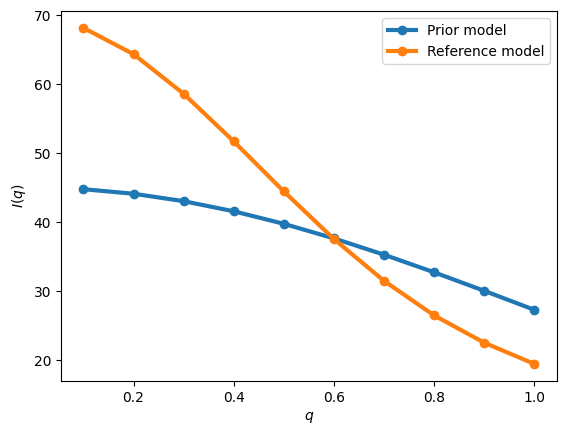

In [12]:
plt.plot(smd_prior.q_SAXS, smd_prior.SAXS, 'o-', label='Prior model', linewidth=3)
plt.plot(smd_test.q_SAXS,1.5*smd_test.SAXS+2.0, 'o-', label='Reference model',linewidth=3)
plt.legend()
plt.xlabel(r'$q$')               
plt.ylabel(r'$I(q)$')
plt.show()

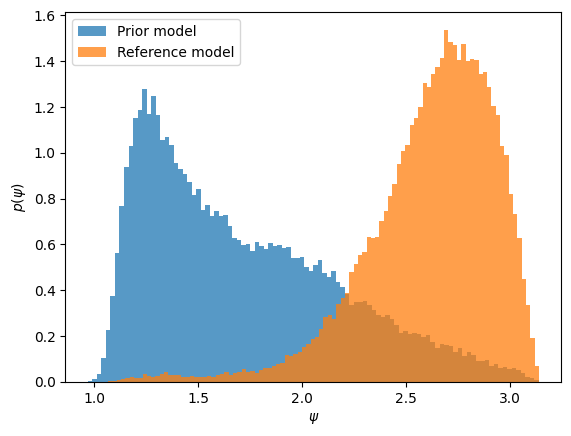

In [13]:
plt.hist(smd_prior.angle[5], bins=100, density=True, alpha=0.75, label='Prior model')
plt.hist(smd_test.angle[5], bins=100, density=True, alpha=0.75, label='Reference model')
plt.legend()
plt.xlabel(r'$\psi$')               
plt.ylabel(r'$p(\psi)$')
plt.show()

In [ ]:
keys_l0={
 'temperature': 0.722,
 'tstep': 0.001,
 'friction': 1.0,
 'forcecutoff': 2.5,
 'k_fene': 30.0,
 'maxbond': 1.5,
 'l_rgyr2': 0.0,
 'q_SAXS': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'exp_SAXS': smd_test.SAXS,
 'k_SAXS': 0.2,
 'tau_SAXS': 50000.0,
 'sigma_SAXS': [1.0],
 'listcutoff': 3.0,
 'nstep': 3010000,
 'nconfig': 1000,
 'nstat': 100,
 'nequilib':10000,
 'nonthefly':2000000,
 }
# generate a crystal lattice and pass it:
keys_l0["cell"] = cell
keys_l0["positions"] = positions

In [ ]:
keys_l1={
 'temperature': 0.722,
 'tstep': 0.001,
 'friction': 1.0,
 'forcecutoff': 2.5,
 'k_fene': 30.0,
 'maxbond': 1.5,
 'l_rgyr2': 0.0,
 'q_SAXS': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'exp_SAXS': smd_test.SAXS,
 'k_SAXS': 0.002,
 'tau_SAXS': 50000.0,
 'sigma_SAXS': [1.0],
 'listcutoff': 3.0,
 'nstep': 3010000,
 'nconfig': 1000,
 'nstat': 100,
 'nequilib':10000,
 'nonthefly':2000000,
 }
# generate a crystal lattice and pass it:
keys_l1["cell"] = cell
keys_l1["positions"] = positions

In [ ]:
keys_l2={
 'temperature': 0.722,
 'tstep': 0.001,
 'friction': 1.0,
 'forcecutoff': 2.5,
 'k_fene': 30.0,
 'maxbond': 1.5,
 'l_rgyr2': 0.0,
 'q_SAXS': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'exp_SAXS': smd_test.SAXS,
 'k_SAXS': 0.2,
 'tau_SAXS': 500.0,
 'sigma_SAXS': [1.0],
 'listcutoff': 3.0,
 'nstep': 3010000,
 'nconfig': 1000,
 'nstat': 100,
 'nequilib':10000,
 'nonthefly':2000000,
 }
# generate a crystal lattice and pass it:
keys_l2["cell"] = cell
keys_l2["positions"] = positions

In [ ]:
keys_l3={
 'temperature': 0.722,
 'tstep': 0.001,
 'friction': 1.0,
 'forcecutoff': 2.5,
 'k_fene': 30.0,
 'maxbond': 1.5,
 'l_rgyr2': 0.0,
 'q_SAXS': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'exp_SAXS': smd_test.SAXS,
 'k_SAXS': 20,
 'tau_SAXS': 50000.0,
 'sigma_SAXS': [1.0],
 'listcutoff': 3.0,
 'nstep': 3010000,
 'nconfig': 1000,
 'nstat': 100,
 'nequilib':10000,
 'nonthefly':2000000,
 }
# generate a crystal lattice and pass it:
keys_l3["cell"] = cell
keys_l3["positions"] = positions

In [ ]:
keys_l4={
 'temperature': 0.722,
 'tstep': 0.001,
 'friction': 1.0,
 'forcecutoff': 2.5,
 'k_fene': 30.0,
 'maxbond': 1.5,
 'l_rgyr2': 0.0,
 'q_SAXS': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'exp_SAXS': smd_test.SAXS,
 'k_SAXS': 0.002,
 'tau_SAXS': 50000.0,
 'sigma_SAXS': [1.0],
 'listcutoff': 3.0,
 'nstep': 3010000,
 'nconfig': 1000,
 'nstat': 100,
 'nequilib':10000,
 'nonthefly':2000000,
 }
# generate a crystal lattice and pass it:
keys_l4["cell"] = cell
keys_l4["positions"] = positions

In [ ]:
# # create runner
# sl0=SimpleMD(**keys_l0)
# # run
# sl0.run()

In [ ]:
# # create runner
# sl1=SimpleMD(**keys_l1)
# # run
# sl1.run()

In [ ]:
# # create runner
# sl2=SimpleMD(**keys_l2)
# # run
# sl2.run()

In [ ]:
# # create runner
# sl3=SimpleMD(**keys_l3)
# # run
# sl3.run()

In [ ]:
# # create runner
# sl4=SimpleMD(**keys_l4)
# # run
# sl4.run()

In [ ]:
with open("../data/posterior_0.2_50000.pkl", "rb") as file:
    sl0 = pickle.load(file)

with open("../data/posterior_0.2_5000000.pkl", "rb") as file:
    sl1 = pickle.load(file)

with open("../data/posterior_0.2_500.pkl", "rb") as file:
    sl2 = pickle.load(file)

with open("../data/posterior_20_50000.pkl", "rb") as file:
    sl3 = pickle.load(file)

with open("../data/posterior_0.002_50000.pkl", "rb") as file:
    sl4 = pickle.load(file)

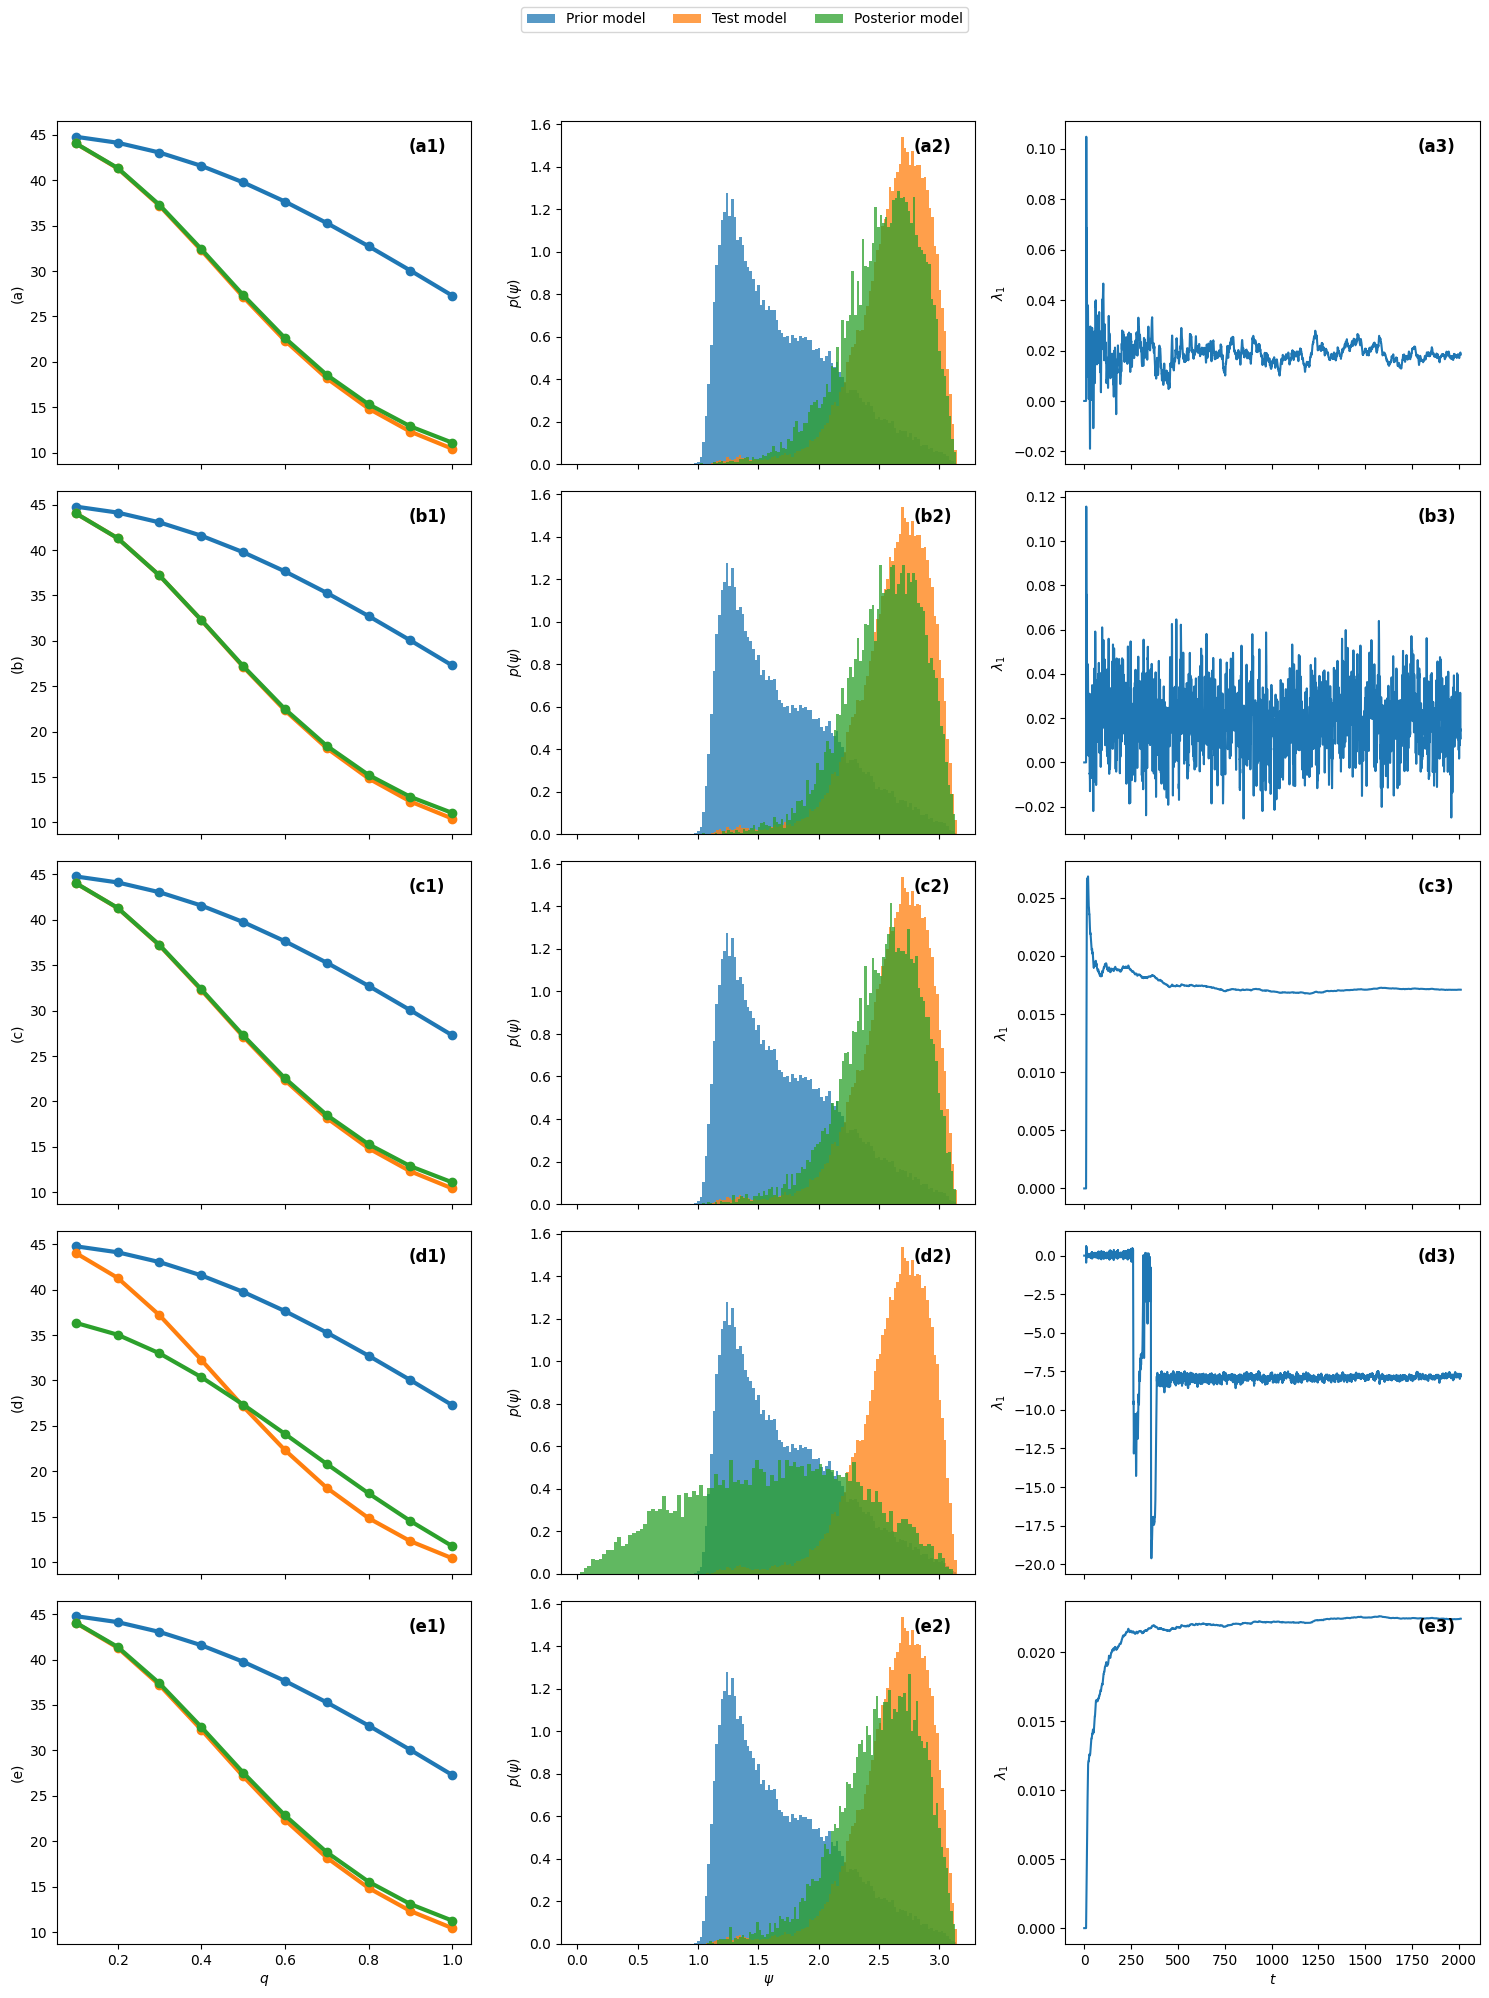

In [ ]:
simulations = ["(a)", "(b)", "(c)", "(d)", "(e)"]
image_types = ["Tipo1", "Tipo2", "Tipo3"]
labels = [['(a1)','(a2)','(a3)'], ['(b1)','(b2)','(b3)'], ['(c1)','(c2)','(c3)'], ['(d1)','(d2)','(d3)'], ['(e1)','(e2)','(e3)']] 


fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20), sharex="col")


for i, sim in enumerate(simulations):
  for j, img_type in enumerate(image_types):
    ax = axes[i, j]

    if j == 0:
      if i==0:
        ax.plot(smd_prior.q_SAXS, smd_prior.SAXS, '-o', label='Prior model',linewidth=3)
        ax.plot(smd_test.q_SAXS, sl0.exp_SAXS, '-o', label='Test model',linewidth=3)
        ax.plot(sl0.q_SAXS, sl0.SAXS, '-o', label='Posterior model',linewidth=3)
        ax.set_ylabel(r'$I(q)$')

      elif i==1:
        ax.plot(smd_prior.q_SAXS, smd_prior.SAXS, '-o', label='Prior model',linewidth=3)
        ax.plot(smd_test.q_SAXS, sl1.exp_SAXS, '-o', label='Test model',linewidth=3)
        ax.plot(sl1.q_SAXS, sl1.SAXS, '-o', label='Posterior model',linewidth=3)
        ax.set_ylabel(r'$I(q)$')


      elif i==2:
        ax.plot(smd_prior.q_SAXS, smd_prior.SAXS, '-o', label='Prior model',linewidth=3)
        ax.plot(smd_test.q_SAXS, sl2.exp_SAXS, '-o', label='Test model',linewidth=3)
        ax.plot(sl2.q_SAXS, sl2.SAXS, '-o', label='Posterior model',linewidth=3)
        ax.set_ylabel(r'$I(q)$')

      elif i==3:
        ax.plot(smd_prior.q_SAXS, smd_prior.SAXS, '-o', label='Prior model',linewidth=3)
        ax.plot(smd_test.q_SAXS, sl3.exp_SAXS, '-o', label='Test model',linewidth=3)
        ax.plot(sl3.q_SAXS, sl3.SAXS, '-o', label='Posterior model',linewidth=3)
        ax.set_ylabel(r'$I(q)$')

      elif i==4:
        ax.plot(smd_prior.q_SAXS, smd_prior.SAXS, '-o', label='Prior model',linewidth=3)
        ax.plot(smd_test.q_SAXS, sl4.exp_SAXS, '-o', label='Test model',linewidth=3)
        ax.plot(sl4.q_SAXS, sl4.SAXS, '-o', label='Posterior model',linewidth=3)
        ax.set_ylabel(r'$I(q)$')
      
      if j == 0:
        ax.set_ylabel(sim)
    elif j == 1: 
        if i == 0: 
            ax.hist(smd_prior.angle[5], bins=100, density=True, alpha=0.75, label='Prior model')
            ax.hist(smd_test.angle[5], bins=100, density=True, alpha=0.75, label='Test model')
            ax.hist(sl0.angle[5][-10000:], bins=100, density=True, alpha=0.75, label='Posterior model')
            ax.set_ylabel(r'$p(\psi)$')
            
        elif i == 1: 
            ax.hist(smd_prior.angle[5], bins=100, density=True, alpha=0.75, label='Prior model')
            ax.hist(smd_test.angle[5], bins=100, density=True, alpha=0.75, label='Test model')
            ax.hist(sl1.angle[5][-10000:], bins=100, density=True, alpha=0.75, label='Posterior model') 
            ax.set_ylabel(r'$p(\psi)$')
            
        elif i == 2: 
            ax.hist(smd_prior.angle[5], bins=100, density=True, alpha=0.75, label='Prior model')
            ax.hist(smd_test.angle[5], bins=100, density=True, alpha=0.75, label='Test model')
            ax.hist(sl2.angle[5][-10000:], bins=100, density=True, alpha=0.75, label='Posterior model') 
            ax.set_ylabel(r'$p(\psi)$')

        elif i == 3: 
            ax.hist(smd_prior.angle[5], bins=100, density=True, alpha=0.75, label='Prior model')
            ax.hist(smd_test.angle[5], bins=100, density=True, alpha=0.75, label='Test model')
            ax.hist(sl3.angle[5][-10000:], bins=100, density=True, alpha=0.75, label='Posterior model') 
            ax.set_ylabel(r'$p(\psi)$')

        elif i == 4: 
            ax.hist(smd_prior.angle[5], bins=100, density=True, alpha=0.75, label='Prior model')
            ax.hist(smd_test.angle[5], bins=100, density=True, alpha=0.75, label='Test model')
            ax.hist(sl4.angle[5][-10000:], bins=100, density=True, alpha=0.75, label='Posterior model') 
            ax.set_ylabel(r'$p(\psi)$')

        
    elif j == 2: 
        if i == 0:
            ax.plot(np.array(sl0.statistics).T[1][:20100],sl0.lambda_otf[0][:20100])
            ax.set_ylabel(r'$\lambda_1$')
            
        elif i == 1:
            ax.plot(np.array(sl1.statistics).T[1][:20100],sl1.lambda_otf[0][:20100])
            ax.set_ylabel(r'$\lambda_1$')
        elif i == 2:
            ax.plot(np.array(sl2.statistics).T[1][:20100],sl2.lambda_otf[0][:20100])
            ax.set_ylabel(r'$\lambda_1$')

        elif i == 3:
          ax.plot(np.array(sl3.statistics).T[1][:20100],sl3.lambda_otf[0][:20100])
          ax.set_ylabel(r'$\lambda_1$')

        elif i == 4:
          ax.plot(np.array(sl4.statistics).T[1][:20100],sl4.lambda_otf[0][:20100])
          ax.set_ylabel(r'$\lambda_1$')


    # Add custom label at the top left of the subplot
    ax.text(0.85, 0.95, labels[i][j], transform=ax.transAxes, fontsize=12, fontweight='bold', va='top')



axes[-1, 0].set_xlabel(r'$q$')
axes[-1, 1].set_xlabel(r'$\psi$')
axes[-1, 2].set_xlabel(r'$t$')



handles, labels_legend = axes[0,1].get_legend_handles_labels() 
fig.legend(handles, labels_legend, loc="upper center", ncol=3,fontsize=20)


plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

In [ ]:
keys_posterior={
 'temperature': 0.722,
 'tstep': 0.001,
 'friction': 1.0,
 'forcecutoff': 2.5,
 'k_fene': 30.0,
 'maxbond': 1.5,
 'l_rgyr2': 0.0,
 'q_SAXS': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'exp_SAXS': smd_test.SAXS,
 'k_SAXS': 0.2,
 'tau_SAXS': 50000.0,
 'sigma_SAXS': [1.0],
 'listcutoff': 3.0,
 'nstep': 3010000,
 'nconfig': 1000,
 'nstat': 100,
 'nequilib':10000,
 'nonthefly':2000000,
 }
# generate a crystal lattice and pass it:
keys_posterior["cell"] = cell
keys_posterior["positions"] = positions

In [19]:
# # create runner
# smd_posterior=SimpleMD(**keys_posterior)
# # run
# smd_posterior.run()

In [ ]:
with open("../data/posterior_0.2_50000.pkl", "rb") as file:
    smd_posterior = pickle.load(file)

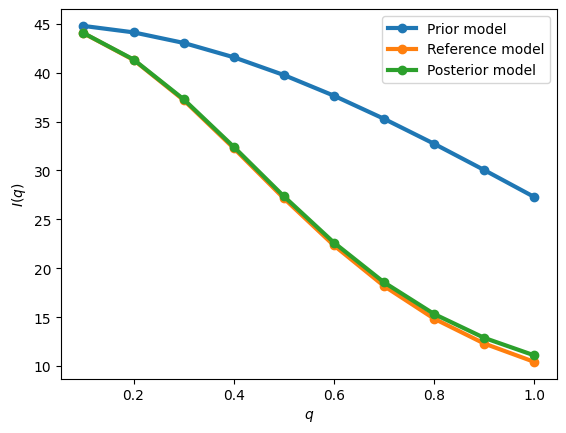

In [31]:
plt.plot(smd_prior.q_SAXS, smd_prior.SAXS, '-o', label='Prior model',linewidth=3)
plt.plot(smd_posterior.q_SAXS, smd_posterior.exp_SAXS, '-o', label='Reference model',linewidth=3)
plt.plot(smd_posterior.q_SAXS, smd_posterior.SAXS, '-o', label='Posterior model',linewidth=3)
plt.legend()
plt.xlabel(r'$q$')               
plt.ylabel(r'$I(q)$')


plt.savefig('SAXSlfinal.pdf', format='pdf', bbox_inches='tight')

plt.show()

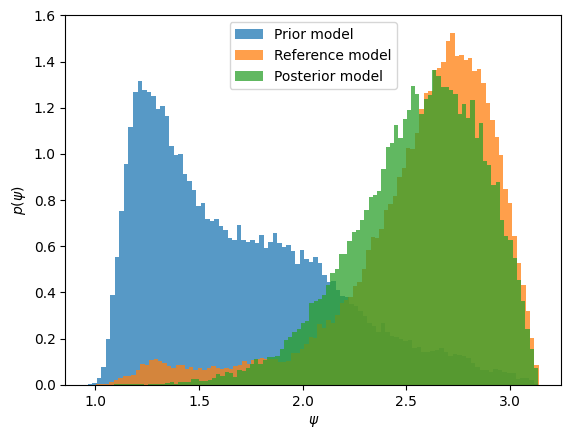

In [32]:
ndata=smd_posterior.nstep-smd_posterior.nonthefly-smd_posterior.nequilib #data collection phase
plt.hist(smd_prior.angle[3], bins=100, density=True, alpha=0.75, label='Prior model')
plt.hist(smd_test.angle[3], bins=100, density=True, alpha=0.75, label='Reference model')
plt.hist(smd_posterior.angle[3][-ndata:], bins=100, density=True, alpha=0.75, label='Posterior model')
plt.xlabel(r'$\psi$')               
plt.ylabel(r'$p(\psi)$')
plt.legend()


plt.show()

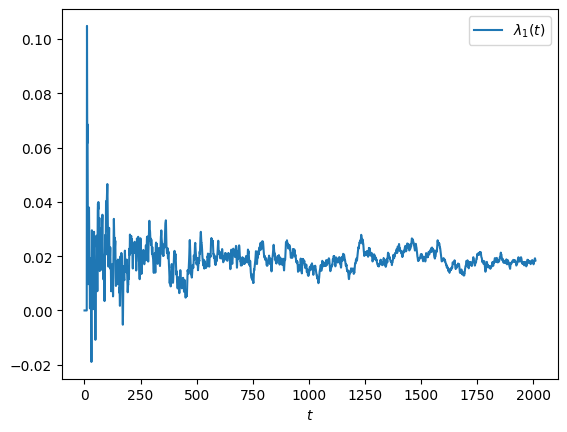

In [33]:
ndata=smd_posterior.nstep-smd_posterior.nonthefly-smd_posterior.nequilib #data collection phase
plt.plot(np.array(smd_posterior.statistics).T[1][:-ndata//smd_posterior.nstat],smd_posterior.lambda_otf[0][:-ndata//smd_posterior.nstat], label=r"$\lambda_1(t)$")
plt.legend()
plt.xlabel(r'$t$')   
plt.savefig('lfinal.pdf', format='pdf', bbox_inches='tight')
plt.show()


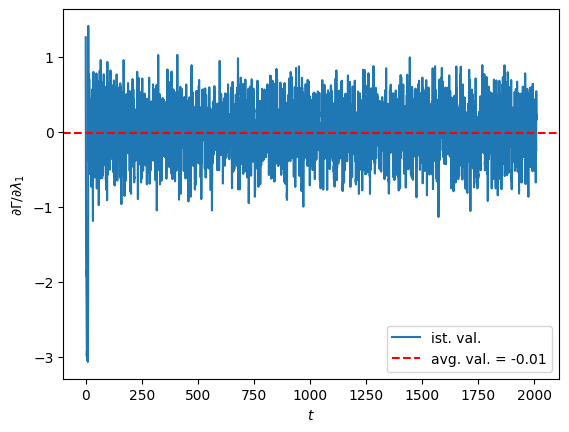

In [34]:
plt.plot(np.array(smd_posterior.statistics).T[1][:-ndata//smd_posterior.nstat],smd_posterior.grad_lambda[1][:-ndata//smd_posterior.nstat], label="ist. val.")
avg=np.mean(smd_posterior.grad_lambda[1][:-ndata//smd_posterior.nstat])
plt.axhline(y=avg, color="r", linestyle="--", label=f"avg. val. = {avg:.2f}")
plt.legend()
plt.xlabel(r'$t$')   
plt.ylabel(r'$\partial \Gamma /\partial \lambda_1$') 
plt.show()